# Hello World

This is my practice notebook while following https://docs.quantum.ibm.com/guides/hello-world.

The four steps to writing a quantum program using Qiskit patterns are:

1. Map the problem to a quantum-native format.

2. Optimize the circuits and operators.

3. Execute using a quantum primitive function.

4. Analyze the results.

## Step 1: Mapping the problem to a quantum-native format

In a quantum program, quantum circuits are the native format in which to represent quantum instructions, and operators represent the observables to be measured. When creating a circuit, we need to a new `QuantumCircuit` object, then add instructions to it in sequence.

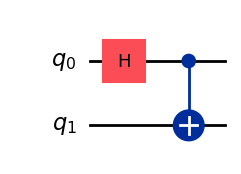

In [1]:
# Code to create a Bell State in which two qubits are completely entangled to each other
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator
 
# Create a new circuit with two qubits
qc = QuantumCircuit(2)
 
# Add a Hadamard gate to qubit 0
qc.h(0)
 
# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)
 
# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

What type of data we want after execution of a quantum circuit? There are two ways to obtain data from a quantum circuit, these are called the qiskit primitives.
1. Probability distribution of of a set of qubit we choose to measure.
2. Expectation value of the observable.

Ref - https://docs.quantum.ibm.com/guides/get-started-with-primitives

In [2]:
# Set up six different observables.
 
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

## Step 2: Optimize the Circuits and Operators

When executing circuits on a device, it is important to optimize the set of instructions that the circuit contains and minimize the overall depth (roughly the number of instructions) of the circuit. This ensures that you obtain the best results possible by reducing the effects of error and noise. Additionally, the circuit's instructions must conform to a backend device's Instruction Set Architecture (ISA) and must consider the device's basis gates and qubit connectivity.

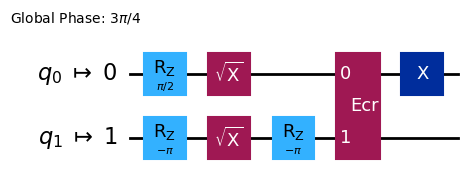

In [3]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
# If you have not previously saved your credentials, follow instructions at
# https://docs.quantum.ibm.com/guides/setup-channel#iqp
# to authenticate with your API token.
service = QiskitRuntimeService()
 
backend = service.least_busy(simulator=False, operational=True)
 
# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
 
isa_circuit.draw("mpl", idle_wires=False) # There are less idle wires in the circuit we dont need to visualize them here.

In [7]:
backend.name # Checks the free platform I have acquired

'ibm_kyiv'

Different IBM Quantum Processing Units can be found here: https://quantum.ibm.com/services/resources


## Step 3: Execute Using Quantum Primitives

Quantum computers can produce random results, so you usually collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable by using the `Estimator` class. `Estimator` is one of two primitives; the other is `Sampler`, which can be used to get data from a quantum computer. These objects possess a `run()` method that executes the selection of circuits, observables, and parameters (if applicable), using a primitive unified bloc (PUB).

In [10]:
# Construct the Estimator instance.
 
estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1 # What does this mean?
estimator.options.default_shots = 5000 # Means that the circuit will be run 5000 times
 
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])
 
# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: cy8c19x01rbg008jgwpg


In [15]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()
 
# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

Run the example using `fake_provider`.

```python
# Use the following code instead if you want to run on a simulator:
 
from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
backend = FakeAlmadenV2()
estimator = Estimator(backend)
 
# Convert to an ISA circuit and layout-mapped observables.
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)
mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]
 
job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()
 
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
 
job_result = job.result()
 
# This is the result from our single pub, which had five observables,
# so contains information on all five.
 
pub_result = job.result()[0]
```


## Step 4: Analyze the Results

The analyze step is typically where you might postprocess your results using, for example, measurement error mitigation or zero noise extrapolation (ZNE). You might feed these results into another workflow for further analysis or prepare a plot of the key values and data. In general, this step is specific to your problem. For this example, plot each of the expectation values that were measured for our circuit.

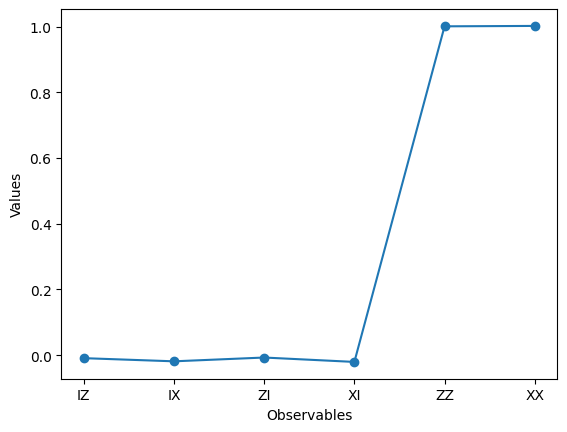

In [16]:
# Plot the result
 
from matplotlib import pyplot as plt
 
values = pub_result.data.evs
 
errors = pub_result.data.stds
 
# plotting graph
plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

Notice that for qubits 0 and 1, the independent expectation values of both `X` and `Z` are 0, while the correlations (`XX` and `ZZ`) are 1. This is a hallmark of quantum entanglement.

# Scale to large number of Qubits

In quantum computing, utility-scale work is crucial for making progress in the field. Such work requires computations to be done on a much larger scale; working with circuits that might use over 100 qubits and over 1000 gates. This example demonstrates how you can accomplish utility-scale work on IBM® QPUs by creating and analyzing a 100-qubit GHZ state. It uses the Qiskit patterns workflow and ends by measuring the expectation value $\langle Z_0Z_i \rangle$ for each qubit.

## Step 1: Map the Problem

In [3]:
from qiskit import QuantumCircuit
 
 
def get_qc_for_n_qubit_GHZ_state(n: int) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit GHZ state.
 
    Args:
        n (int): Number of qubits in the n-qubit GHZ state
 
    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit GHZ state, assuming all qubits start in the 0 state
    """
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n - 1):
            qc.cx(i, i + 1)
    else:
        raise Exception("n is not a valid input")
    return qc
 
 
# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
n = 3
qc = get_qc_for_n_qubit_GHZ_state(n)

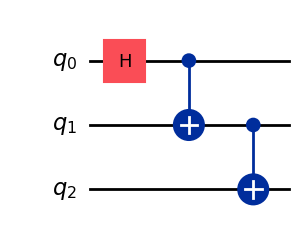

In [4]:
qc.draw("mpl")

In [5]:
from qiskit.quantum_info import SparsePauliOp
 
# ZZII...II, ZIZI...II, ... , ZIII...IZ
operator_strings = [
    "Z" + "I" * i + "Z" + "I" * (n - 2 - i) for i in range(n - 1)
]
print(operator_strings)
print(len(operator_strings))
 
operators = [SparsePauliOp(operator) for operator in operator_strings]

['ZZI', 'ZIZ']
2


## Step 2: Optimize the problem for execution on quantum hardware